# 03 — Aperturas y cierres: cortos vs largos (bins de 4 min) y respuesta hidráulica

## Objetivo
Con muestreo $\Delta t \approx 1$ min, cuantificar:

1. **Aperturas** (subidas de caudal) y **cierres** (bajadas de caudal) con cambio neto significativo.
2. Separarlas en **intervalos de duración / subida** de 4 minutos:  
   $$[0,4),\ [4,8),\ [8,12),\ [12,16),\ [16,+\infty)$$
3. Medir la respuesta del sistema en horizontes fijos, usando baseline en **$t_0-1$ min**:
   - $t_0$ (inicio)
   - $t_0+4$, $t_0+8$, $t_0+12$, $t_0+16$ min

Esto permite comparar, de forma consistente, **eventos cortos vs largos** y la respuesta en presión asociada.

---

## Variables
- $P_g(t)$: presión manométrica [bar]
- $Q(t)$: caudal [L/s]
- $\Delta P_{1\mathrm{min}}$: cambio por minuto [bar/min]
- $\Delta Q_{1\mathrm{min}}$: cambio por minuto [L/s/min]

## Conversión hidráulica (DN315)
Con $D=0.315$ m:
$$
A=\frac{\pi D^2}{4}, \qquad V(t)=\frac{Q(t)}{A}
$$
y:
$$
\Delta V_{1\mathrm{min}}=\frac{\Delta Q_{1\mathrm{min}}}{A}
$$

> Nota: como $\Delta t$ es 1 min, un transiente real de segundos puede verse “compactado” en una o pocas muestras. El análisis por horizontes ($0/4/8/12/16$ min) busca capturar la **huella** del evento.


In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

PROJECT_ROOT = Path('/home/maxi/datascience_esval')
CLEAN_FILE = PROJECT_ROOT / 'data' / 'processed' / 'sensores_1min_clean.parquet'

OUT_EVENTS = PROJECT_ROOT / 'data' / 'processed' / 'eventos_apertura_cierre.parquet'
OUT_HORIZ = PROJECT_ROOT / 'data' / 'processed' / 'eventos_apertura_cierre_horizontes.parquet'

CLEAN_FILE.exists(), CLEAN_FILE


(True,
 PosixPath('/home/maxi/datascience_esval/data/processed/sensores_1min_clean.parquet'))

## 1) Carga del dataset (1-min, limpio)

In [14]:
g = pd.read_parquet(CLEAN_FILE)
g.index = pd.to_datetime(g.index)
g = g.sort_index()
g.index.name = 't'

P_COL = 'p_bar'
Q_COL = 'q_lps'
dP_COL = 'dP_bar_clean'
dQ_COL = 'dQ_lps_clean'
MISS_COL = 'is_missing_any'

g.shape, g.index.min(), g.index.max(), g.columns.tolist()


((475201, 9),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2025-11-27 00:00:00'),
 ['p_bar',
  'q_lps',
  'dP_bar_clean',
  'dQ_lps_clean',
  'is_missing_p',
  'is_missing_q',
  'is_missing_any',
  'gap_len_min',
  'is_q_at_max'])

## 2) Geometría y variables derivadas

In [15]:
D = 0.315  # m
A = np.pi * (D**2) / 4  # m^2

df = g.copy()
df['is_valid'] = (~df[MISS_COL]) & df[P_COL].notna() & df[Q_COL].notna()

df['q_m3s'] = df[Q_COL] / 1000.0
df['v_ms'] = df['q_m3s'] / A

df['dQ_m3s'] = df[dQ_COL] / 1000.0
df['dV_ms'] = df['dQ_m3s'] / A

print('A (m^2)=', float(A))
display(df.loc[df['is_valid'], ['v_ms','dV_ms',P_COL,Q_COL,dP_COL,dQ_COL]].describe(
    percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]
).T)


A (m^2)= 0.07793113276311181


,count,mean,std,min,1%,5%,50%,95%,99%,99.9%,max
v_ms,462130.0,0.635147,0.250680,0.000000,0.215190,0.247270,0.644030,1.029755,1.148065,1.262782,1.270352
dV_ms,460173.0,-0.000002,0.026967,-1.057472,-0.043115,-0.022969,0.000000,0.022969,0.044526,0.271265,1.058627
p_bar,462130.0,1.463275,0.264075,0.000000,0.917255,0.971270,1.520423,1.829509,1.981551,2.021562,2.203613
q_lps,462130.0,49.497705,19.535785,0.000000,16.770000,19.270000,50.190000,80.250000,89.470000,98.410000,99.000000
dP_bar_clean,460173.0,-0.000003,0.040547,-1.534427,-0.076021,-0.044012,0.000000,0.044012,0.078022,0.322090,1.283357
dQ_lps_clean,460173.0,-0.000146,2.101559,-82.410000,-3.360000,-1.790000,0.000000,1.790000,3.470000,21.140000,82.500000


## 3) Parámetros de detección y horizontes

Se detectan eventos de:
- **Apertura**: $\Delta Q_{1\mathrm{min}} > q_{\mathrm{start}}$ y $\Delta Q_{\mathrm{total}} \ge q_{\mathrm{total}}$
- **Cierre**: $\Delta Q_{1\mathrm{min}} < -q_{\mathrm{start}}$ y $\Delta Q_{\mathrm{total}} \le -q_{\mathrm{total}}$

Fin del evento cuando el cambio por minuto se “apaga” durante `end_hold` minutos:
$$
|\Delta Q_{1\mathrm{min}}|\le q_{\mathrm{end}}
$$

### Horizontes de evaluación (baseline en $t_0-1$)
Definimos $t_0$ como el inicio del evento. Luego calculamos:

- baseline: $t_{-1} = t_0 - 1\ \mathrm{min}$
- horizontes: $t_0,\ t_0+4,\ t_0+8,\ t_0+12,\ t_0+16$

y evaluamos:
$$
\Delta Q_h = Q(t_0+h) - Q(t_{-1}),\qquad
\Delta P_h = P_g(t_0+h) - P_g(t_{-1})
$$


In [16]:
# --- parámetros de detección (ajustables) ---
q_total_thr = 16.0   # L/s (cambio neto mínimo)
q_start_thr = 2.0    # L/s/min (disparo inicio)
q_end_thr = 1.0      # L/s/min (criterio fin)
end_hold = 2         # min consecutivos con |dQ|<=q_end_thr para declarar fin
min_duration = 1     # min
max_duration = 60    # min (más permisivo ahora para capturar eventos largos)

# baseline y horizontes (min)
baseline_min = 1
horizons_min = [0, 4, 8, 12, 16]

# bins de 4 min para "corto vs largo"
bin_edges = [0, 4, 8, 12, 16, 10_000]  # 16+ en el último
bin_labels = ['0-4', '4-8', '8-12', '12-16', '16+']

(q_total_thr, q_start_thr, q_end_thr, end_hold, max_duration, horizons_min)


(16.0, 2.0, 1.0, 2, 60, [0, 4, 8, 12, 16])

## 4) Detección de eventos: aperturas y cierres

Reglas:
- No cruzar gaps: si hay missing, se corta el evento.
- Inicio:
  - apertura: $\Delta Q_{1\mathrm{min}} > q_{\mathrm{start}}$
  - cierre: $\Delta Q_{1\mathrm{min}} < -q_{\mathrm{start}}$
- Fin: $|\Delta Q_{1\mathrm{min}}|\le q_{\mathrm{end}}$ durante `end_hold` minutos, o por `max_duration`.
- Filtrado por cambio neto: $|\Delta Q_{\mathrm{total}}|\ge q_{\mathrm{total}}$ con signo coherente.

Además calculamos:
- duración
- $\Delta Q_{\mathrm{total}}$
- $\max|\Delta Q_{1\mathrm{min}}|$ dentro del evento
- respuesta extrema de presión:
  - aperturas: $\Delta P_{\min}=\min(\Delta P)$
  - cierres: $\Delta P_{\max}=\max(\Delta P)$


In [17]:
def detect_events(df: pd.DataFrame,
                  kind: str,
                  q_total_thr=16.0, q_start_thr=2.0, q_end_thr=1.0,
                  end_hold=2, min_duration=1, max_duration=60):
    assert kind in ('open', 'close')
    t = df.index.values
    q = df[Q_COL].values
    p = df[P_COL].values
    dq = df[dQ_COL].values
    dp = df[dP_COL].values
    valid = df['is_valid'].values

    events = []
    in_evt = False
    start = None
    hold = 0

    def is_start(dq_i):
        return (dq_i > q_start_thr) if kind == 'open' else (dq_i < -q_start_thr)

    n = len(df)
    for i in range(n):
        if not valid[i] or np.isnan(q[i]) or np.isnan(p[i]) or np.isnan(dq[i]) or np.isnan(dp[i]):
            if in_evt:
                in_evt = False
                start = None
                hold = 0
            continue

        if not in_evt:
            if is_start(dq[i]):
                j = i-1 if i > 0 and valid[i-1] and not np.isnan(q[i-1]) else i
                start = j
                in_evt = True
                hold = 0
        else:
            dur = i - start
            if dur > max_duration:
                end = i
                in_evt = False
            else:
                if abs(dq[i]) <= q_end_thr:
                    hold += 1
                else:
                    hold = 0
                if hold >= end_hold and dur >= min_duration:
                    end = i
                    in_evt = False
                else:
                    continue

            if start is not None:
                s = start
                e = end

                q_start = float(q[s])
                q_end = float(np.nanmedian(q[max(s, e-2):e+1])) if e >= s else float(q[e])
                dQ_total = q_end - q_start

                # signo coherente
                ok = (dQ_total >= q_total_thr) if kind == 'open' else (dQ_total <= -q_total_thr)
                if ok and np.isfinite(dQ_total):
                    core = slice(s, e+1)
                    max_abs_dQ = float(np.nanmax(np.abs(dq[core]))) if np.isfinite(dq[core]).any() else np.nan
                    min_dP = float(np.nanmin(dp[core])) if np.isfinite(dp[core]).any() else np.nan
                    max_dP = float(np.nanmax(dp[core])) if np.isfinite(dp[core]).any() else np.nan
                    min_P = float(np.nanmin(p[core])) if np.isfinite(p[core]).any() else np.nan
                    max_P = float(np.nanmax(p[core])) if np.isfinite(p[core]).any() else np.nan

                    events.append({
                        'type': 'apertura' if kind=='open' else 'cierre',
                        'start': pd.Timestamp(t[s]),
                        'end': pd.Timestamp(t[e]),
                        'duration_min': float((pd.Timestamp(t[e]) - pd.Timestamp(t[s])).total_seconds()/60.0),
                        'q_start_lps': q_start,
                        'q_end_lps': q_end,
                        'dQ_total_lps': float(dQ_total),
                        'max_abs_dQ_1min_lps': max_abs_dQ,
                        'min_dP_bar': min_dP,
                        'max_dP_bar': max_dP,
                        'min_P_bar': min_P,
                        'max_P_bar': max_P,
                    })

            start = None
            hold = 0

    return pd.DataFrame(events).sort_values('start').reset_index(drop=True)

opens = detect_events(df, 'open', q_total_thr, q_start_thr, q_end_thr, end_hold, min_duration, max_duration)
closes = detect_events(df, 'close', q_total_thr, q_start_thr, q_end_thr, end_hold, min_duration, max_duration)

events = pd.concat([opens, closes], ignore_index=True).sort_values('start').reset_index(drop=True)

events.shape, events.head()


((2658, 12),
        type               start                 end  duration_min  q_start_lps  q_end_lps  dQ_total_lps  max_abs_dQ_1min_lps  min_dP_bar  \
 0    cierre 2025-01-01 01:05:00 2025-01-01 01:08:00           3.0        63.14      43.21        -19.93                20.10   -0.051014   
 1  apertura 2025-01-02 09:04:00 2025-01-02 09:11:00           7.0        63.65      89.23         25.58                17.98   -0.730203   
 2    cierre 2025-01-02 09:11:00 2025-01-02 09:18:00           7.0        89.45      68.27        -21.18                17.22   -0.030008   
 3  apertura 2025-01-02 09:50:00 2025-01-02 09:56:00           6.0        69.28      89.50         20.22                13.62   -0.222062   
 4  apertura 2025-01-02 10:34:00 2025-01-02 10:39:00           5.0        75.76      94.49         18.73                10.51   -0.701195   
 
    max_dP_bar  min_P_bar  max_P_bar  
 0    0.025007   1.102307   1.127314  
 1    0.066018   0.790220   1.541429  
 2    0.679189   0.856

## 5) $t_{\mathrm{rise}}$ y bins de 4 minutos

Definimos $t_{\mathrm{rise}}$ como el tiempo entre alcanzar 10% y 90% del cambio total del evento.

Para aperturas:
- objetivo 10% y 90% por arriba del inicio

Para cierres:
- objetivo 10% y 90% por abajo del inicio (usamos magnitud $|\Delta Q|$)

Luego asignamos bins:
$$
[0,4),\ [4,8),\ [8,12),\ [12,16),\ [16,+\infty)
$$


In [18]:
def first_time_reach(arr, target, kind='ge'):
    if kind == 'ge':
        idx = np.where(arr >= target)[0]
    else:
        idx = np.where(arr <= target)[0]
    return int(idx[0]) if len(idx) else None

def compute_rise_time(df: pd.DataFrame, ev_row):
    s = ev_row['start']; e = ev_row['end']
    core = df.loc[s:e, Q_COL].astype(float)
    if core.empty:
        return np.nan
    q = core.values
    q0 = float(q[0])
    dq_total = float(ev_row['dQ_total_lps'])

    # aperturas: dq_total > 0; cierres: dq_total < 0
    if dq_total > 0:
        q10 = q0 + 0.1*dq_total
        q90 = q0 + 0.9*dq_total
        i10 = first_time_reach(q, q10, 'ge')
        i90 = first_time_reach(q, q90, 'ge')
    else:
        # cierre: q baja; definimos en términos de magnitud
        dq_mag = abs(dq_total)
        q10 = q0 - 0.1*dq_mag
        q90 = q0 - 0.9*dq_mag
        i10 = first_time_reach(q, q10, 'le')
        i90 = first_time_reach(q, q90, 'le')

    if i10 is None or i90 is None or i90 < i10:
        return np.nan
    return float(i90 - i10)

events = events.copy()
events['rise_time_min'] = events.apply(lambda r: compute_rise_time(df, r), axis=1)

# bins 4 min
events['rise_bin_4min'] = pd.cut(
    events['rise_time_min'].fillna(-1),
    bins=[-1.5, 3.999, 7.999, 11.999, 15.999, 10_000],
    labels=bin_labels
)

events['dur_bin_4min'] = pd.cut(
    events['duration_min'].clip(lower=0),
    bins=bin_edges,
    labels=bin_labels,
    right=False
)

events[['type','duration_min','rise_time_min','rise_bin_4min','dur_bin_4min']].head()


,type,duration_min,rise_time_min,rise_bin_4min,dur_bin_4min
0,cierre,3.0,0.0,0-4,0-4
1,apertura,7.0,3.0,0-4,4-8
2,cierre,7.0,1.0,0-4,4-8
3,apertura,6.0,3.0,0-4,4-8
4,apertura,5.0,1.0,0-4,4-8


## 6) Horizontes: baseline $t_0-1$ y evaluación en $0/4/8/12/16$ min

Para cada evento, definimos:
- $t_{-1}=t_0-1$ min (baseline)
- $t_h=t_0+h$ con $h\in\{0,4,8,12,16\}$

Calculamos:
$$
\Delta Q_h = Q(t_h)-Q(t_{-1}),\qquad \Delta P_h = P_g(t_h)-P_g(t_{-1})
$$

Esto permite cuantificar “cuánto del cambio ocurrió en 4 min, 8 min, …” y cómo respondió la presión.


In [19]:
def safe_get(df, ts, col):
    # retorna NaN si no existe timestamp o valor
    try:
        v = df.at[ts, col]
    except KeyError:
        return np.nan
    return float(v) if pd.notna(v) else np.nan

rows = []
for r in events.itertuples(index=False):
    t0 = pd.Timestamp(r.start)
    t_base = t0 - pd.Timedelta(minutes=baseline_min)

    q_base = safe_get(df, t_base, Q_COL)
    p_base = safe_get(df, t_base, P_COL)

    out = {
        'type': r.type,
        'start': t0,
        'end': pd.Timestamp(r.end),
        'duration_min': float(r.duration_min),
        'dQ_total_lps': float(r.dQ_total_lps),
        'rise_time_min': float(r.rise_time_min) if pd.notna(r.rise_time_min) else np.nan,
        'rise_bin_4min': r.rise_bin_4min,
        'dur_bin_4min': r.dur_bin_4min,
        'q_base_lps': q_base,
        'p_base_bar': p_base,
    }

    for hmin in horizons_min:
        th = t0 + pd.Timedelta(minutes=int(hmin))
        qh = safe_get(df, th, Q_COL)
        ph = safe_get(df, th, P_COL)
        out[f'dQ_{hmin}min_lps'] = qh - q_base if np.isfinite(qh) and np.isfinite(q_base) else np.nan
        out[f'dP_{hmin}min_bar'] = ph - p_base if np.isfinite(ph) and np.isfinite(p_base) else np.nan

    rows.append(out)

horiz = pd.DataFrame(rows)

horiz.shape, horiz.head()


((2658, 20),
        type               start                 end  duration_min  dQ_total_lps  rise_time_min rise_bin_4min dur_bin_4min  q_base_lps  \
 0    cierre 2025-01-01 01:05:00 2025-01-01 01:08:00           3.0        -19.93            0.0           0-4          0-4       64.21   
 1  apertura 2025-01-02 09:04:00 2025-01-02 09:11:00           7.0         25.58            3.0           0-4          4-8       64.66   
 2    cierre 2025-01-02 09:11:00 2025-01-02 09:18:00           7.0        -21.18            1.0           0-4          4-8       89.23   
 3  apertura 2025-01-02 09:50:00 2025-01-02 09:56:00           6.0         20.22            3.0           0-4          4-8       68.70   
 4  apertura 2025-01-02 10:34:00 2025-01-02 10:39:00           5.0         18.73            1.0           0-4          4-8       74.77   
 
    p_base_bar  dQ_0min_lps  dP_0min_bar  dQ_4min_lps  dP_4min_bar  dQ_8min_lps  dP_8min_bar  dQ_12min_lps  dP_12min_bar  dQ_16min_lps  \
 0    1.153321     

## 7) Tablas de cuantificación: cortos vs largos (bins 4 min)

Reportamos por tipo (apertura/cierre) y bin (rise_bin y dur_bin):
- conteo
- medianas de $\Delta Q_{\mathrm{total}}$
- severidad en presión:
  - aperturas: $\Delta P_{\min}$ y/o $\Delta P_{16}$
  - cierres: $\Delta P_{\max}$ y/o $\Delta P_{16}$

También mostramos cómo evoluciona $\Delta Q_h$ y $\Delta P_h$ con $h=0,4,8,12,16$.


In [20]:
# resumen por rise_bin
def summarize_by_bin(horiz, bin_col):
    g1 = (horiz.groupby(['type', bin_col])
               .agg(
                   n=('start','size'),
                   dQ_total_med=('dQ_total_lps','median'),
                   rise_med=('rise_time_min','median'),
                   dur_med=('duration_min','median'),
                   dQ_4_med=('dQ_4min_lps','median'),
                   dQ_16_med=('dQ_16min_lps','median'),
                   dP_4_med=('dP_4min_bar','median'),
                   dP_16_med=('dP_16min_bar','median'),
               )
               .reset_index())
    return g1

sum_rise = summarize_by_bin(horiz, 'rise_bin_4min')
sum_dur = summarize_by_bin(horiz, 'dur_bin_4min')

print('Resumen por rise_bin_4min:')
display(sum_rise)

print('\nResumen por dur_bin_4min:')
display(sum_dur)


Resumen por rise_bin_4min:


,type,rise_bin_4min,n,dQ_total_med,rise_med,dur_med,dQ_4_med,dQ_16_med,dP_4_med,dP_16_med
0,apertura,0-4,1004,22.655,1.0,4.0,22.26,1.330,-0.212059,0.006002
1,apertura,12-16,3,29.110,15.0,19.0,3.16,28.850,-0.044012,-0.247069
2,apertura,16+,3,23.750,16.0,19.0,19.24,8.450,-0.214060,-0.076021
3,apertura,4-8,73,22.480,5.0,9.0,3.73,2.880,-0.060017,0.013004
4,apertura,8-12,20,23.175,9.0,14.0,1.68,16.410,-0.035510,-0.065518
5,cierre,0-4,1483,-22.160,1.0,5.0,-21.98,-21.760,0.251070,0.223062
6,cierre,12-16,3,-62.480,14.0,21.0,-15.16,-46.840,0.121034,0.163045
7,cierre,16+,1,-45.360,22.0,33.0,-7.76,-28.280,0.126035,0.260072
8,cierre,4-8,58,-24.040,5.0,9.5,-16.18,-21.380,0.203056,0.217060
9,cierre,8-12,10,-27.270,9.0,13.0,-3.78,-24.325,0.055515,0.210058



Resumen por dur_bin_4min:


,type,dur_bin_4min,n,dQ_total_med,rise_med,dur_med,dQ_4_med,dQ_16_med,dP_4_med,dP_16_med
0,apertura,0-4,144,21.465,0.0,3.0,20.540,1.430,-0.189053,-0.004001
1,apertura,12-16,34,23.045,5.0,13.0,9.895,3.680,-0.071020,-0.004001
2,apertura,16+,17,23.790,11.0,19.0,3.160,18.500,-0.044012,-0.154043
3,apertura,4-8,824,22.910,1.0,5.0,22.650,1.360,-0.215060,0.007002
4,apertura,8-12,84,22.635,4.0,9.0,4.025,1.545,-0.042012,0.016004
5,cierre,0-4,157,-20.570,0.0,3.0,-20.930,-21.030,0.200056,0.183551
6,cierre,12-16,91,-23.160,1.0,13.0,-21.660,-22.480,0.255571,0.237066
7,cierre,16+,44,-23.090,1.0,19.0,-22.125,-22.605,0.237566,0.217060
8,cierre,4-8,978,-22.320,1.0,5.0,-22.040,-21.870,0.256071,0.224062
9,cierre,8-12,285,-22.730,1.0,9.0,-21.840,-21.920,0.241067,0.227063


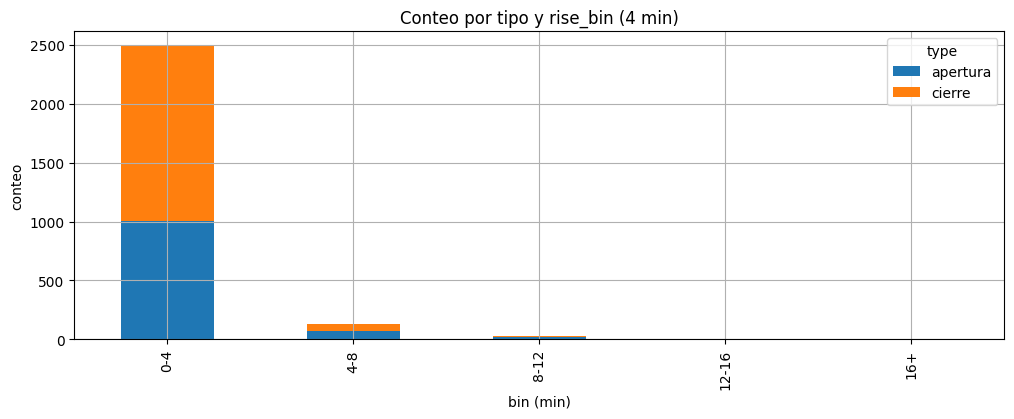

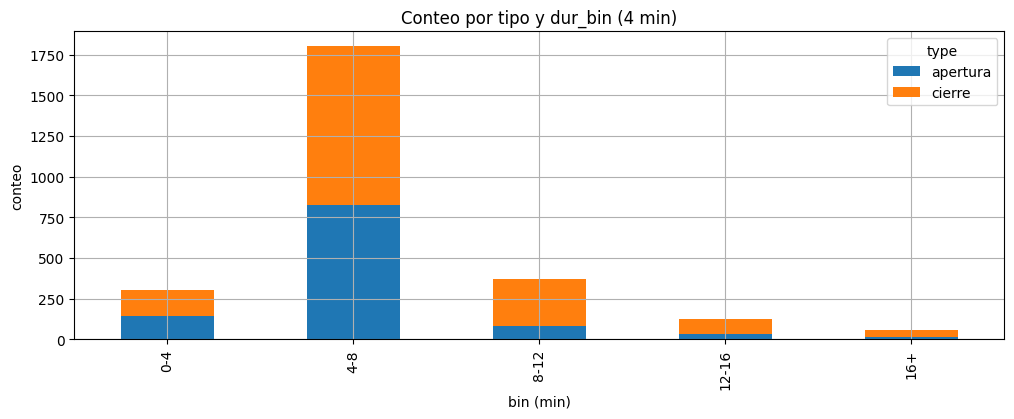

rise_bin_4min,0-4,4-8,8-12,12-16,16+
type,,,,,
apertura,1004,73,20,3,3
cierre,1483,58,10,3,1


dur_bin_4min,0-4,4-8,8-12,12-16,16+
type,,,,,
apertura,144,824,84,34,17
cierre,157,978,285,91,44


In [21]:
# Conteos (stacked) por tipo y bin
def stacked_counts(horiz, bin_col, title):
    c = (horiz.groupby(['type', bin_col]).size().unstack(fill_value=0))
    c = c.reindex(columns=bin_labels, fill_value=0)
    c.T.plot(kind='bar', stacked=True, figsize=(12,4))
    plt.title(title)
    plt.xlabel('bin (min)')
    plt.ylabel('conteo')
    plt.show()
    return c

c_rise = stacked_counts(horiz, 'rise_bin_4min', 'Conteo por tipo y rise_bin (4 min)')
c_dur = stacked_counts(horiz, 'dur_bin_4min', 'Conteo por tipo y dur_bin (4 min)')
display(c_rise)
display(c_dur)


## 8) Curvas promedio por bin: $\Delta Q_h$ y $\Delta P_h$

Para cada bin, graficamos la mediana de:
- $\Delta Q_h$ en $h=\{0,4,8,12,16\}$
- $\Delta P_h$ en $h=\{0,4,8,12,16\}$

Esto muestra si los eventos “largos” construyen el cambio lentamente y si la presión responde distinto.


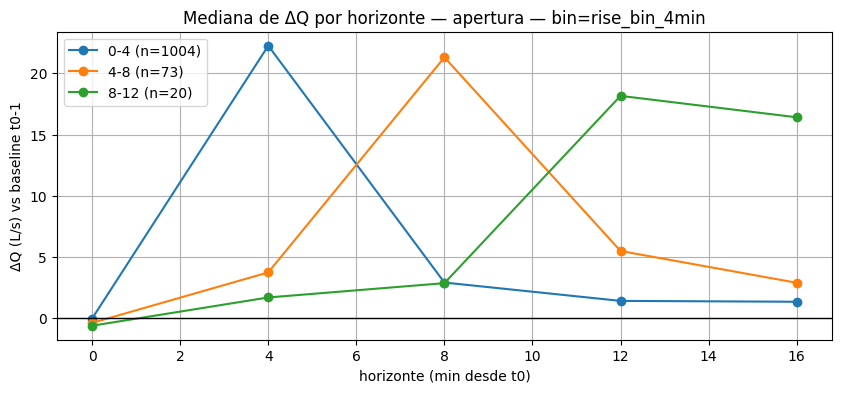

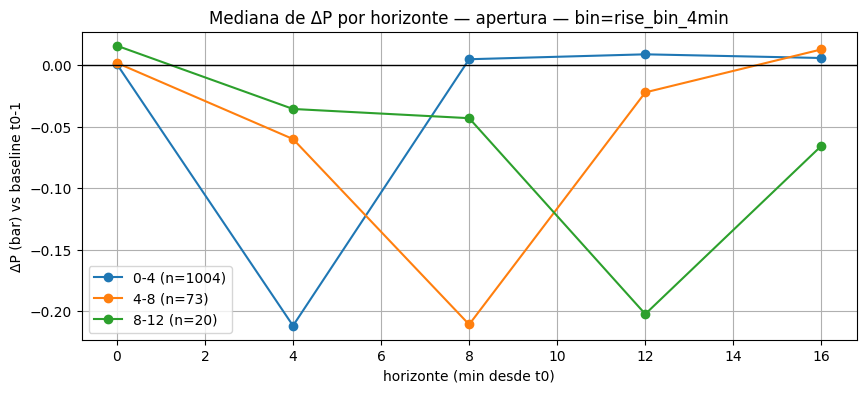

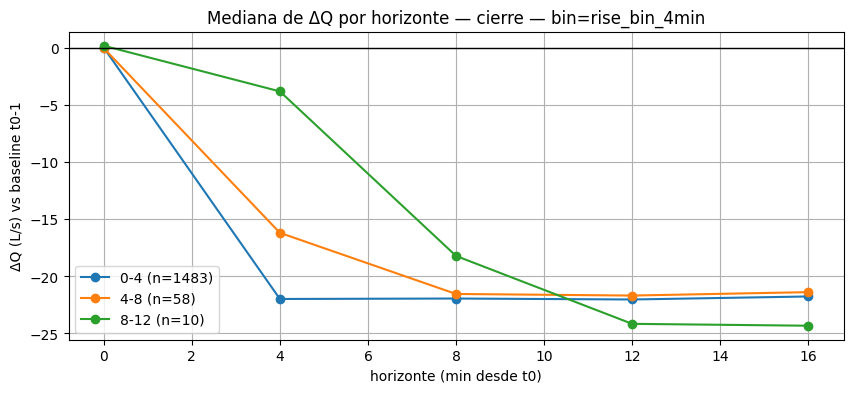

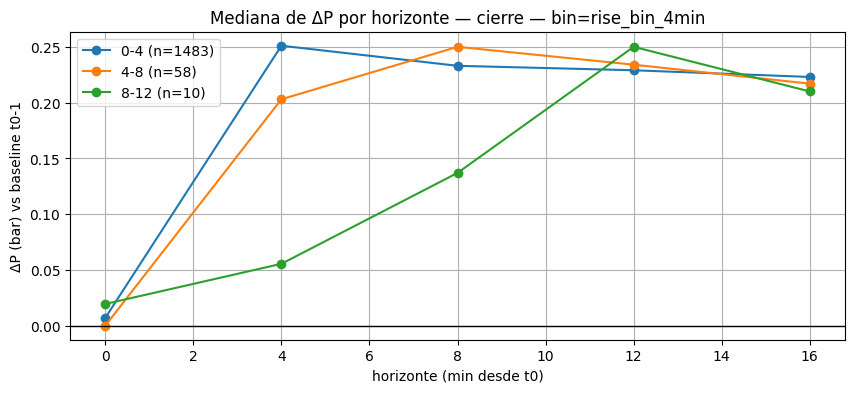

In [22]:
# Curvas medianas por bin: ΔQ_h y ΔP_h
H = horizons_min

def plot_median_curves(horiz, bin_col, typ, what='Q', min_n=10):
    assert what in ('Q','P')

    if what == 'Q':
        colfmt = lambda h: f'dQ_{h}min_lps'
        ylab = 'ΔQ (L/s) vs baseline t0-1'
    else:
        colfmt = lambda h: f'dP_{h}min_bar'
        ylab = 'ΔP (bar) vs baseline t0-1'

    plt.figure(figsize=(10,4))
    sub = horiz[horiz['type'] == typ].copy()

    # chequeo rápido de columnas esperadas
    missing_cols = [colfmt(h) for h in H if colfmt(h) not in sub.columns]
    if missing_cols:
        raise KeyError(f'Faltan columnas en horiz: {missing_cols}')

    for lab in bin_labels:
        s = sub[sub[bin_col] == lab]
        if len(s) < min_n:
            continue
        y = [float(np.nanmedian(s[colfmt(h)].values)) for h in H]
        plt.plot(H, y, marker='o', label=f'{lab} (n={len(s)})')

    plt.title(f'Mediana de Δ{what} por horizonte — {typ} — bin={bin_col}')
    plt.xlabel('horizonte (min desde t0)')
    plt.ylabel(ylab)
    plt.axhline(0, color='k', linewidth=1)
    plt.legend()
    plt.show()

plot_median_curves(horiz, 'rise_bin_4min', 'apertura', what='Q')
plot_median_curves(horiz, 'rise_bin_4min', 'apertura', what='P')
plot_median_curves(horiz, 'rise_bin_4min', 'cierre', what='Q')
plot_median_curves(horiz, 'rise_bin_4min', 'cierre', what='P')


## 9) Guardar resultados

Se guardan:
- `eventos_apertura_cierre.parquet`: tabla base por evento
- `eventos_apertura_cierre_horizontes.parquet`: tabla por evento con horizontes (baseline -1 y 0/4/8/12/16)


In [23]:
OUT_EVENTS.parent.mkdir(parents=True, exist_ok=True)
OUT_HORIZ.parent.mkdir(parents=True, exist_ok=True)

events.to_parquet(OUT_EVENTS, index=False)
horiz.to_parquet(OUT_HORIZ, index=False)

OUT_EVENTS, OUT_HORIZ


(PosixPath('/home/maxi/datascience_esval/data/processed/eventos_apertura_cierre.parquet'),
 PosixPath('/home/maxi/datascience_esval/data/processed/eventos_apertura_cierre_horizontes.parquet'))

## Resumen 

La celda siguiente imprime un resumen compacto:
- conteos de aperturas/cierres
- conteos por bins 4 min (rise y duración)
- medianas de respuesta en horizontes 4 y 16 min
- rutas de salida


In [24]:
print('=== RESUMEN DATASET (03) ===')

print('\nEntrada:')
print('CLEAN_FILE:', CLEAN_FILE)

print('\nGeometría:')
print('D (m):', D)
print('A (m^2):', float(A))

print('\nParámetros detección:')
print('q_total_thr:', q_total_thr)
print('q_start_thr:', q_start_thr)
print('q_end_thr:', q_end_thr)
print('end_hold:', end_hold)
print('max_duration:', max_duration)

print('\nHorizontes:')
print('baseline_min:', baseline_min)
print('horizons_min:', horizons_min)
print('bins (4 min):', bin_labels)

print('\nConteos:')
print('n_eventos_total:', int(len(events)))
print('por tipo:', events['type'].value_counts().to_dict())

print('\nConteos por rise_bin_4min (por tipo):')
tab_rise = (horiz.groupby(['type','rise_bin_4min']).size().unstack(fill_value=0)).reindex(columns=bin_labels, fill_value=0)
display(tab_rise)

print('\nConteos por dur_bin_4min (por tipo):')
tab_dur = (horiz.groupby(['type','dur_bin_4min']).size().unstack(fill_value=0)).reindex(columns=bin_labels, fill_value=0)
display(tab_dur)

print('\nResumen por rise_bin_4min (medianas):')
display(sum_rise)

print('\nResumen por dur_bin_4min (medianas):')
display(sum_dur)

print('\nSalidas:')
print('OUT_EVENTS:', OUT_EVENTS)
print('OUT_HORIZ:', OUT_HORIZ)

print('=== FIN ===')


=== RESUMEN DATASET (03) ===

Entrada:
CLEAN_FILE: /home/maxi/datascience_esval/data/processed/sensores_1min_clean.parquet

Geometría:
D (m): 0.315
A (m^2): 0.07793113276311181

Parámetros detección:
q_total_thr: 16.0
q_start_thr: 2.0
q_end_thr: 1.0
end_hold: 2
max_duration: 60

Horizontes:
baseline_min: 1
horizons_min: [0, 4, 8, 12, 16]
bins (4 min): ['0-4', '4-8', '8-12', '12-16', '16+']

Conteos:
n_eventos_total: 2658
por tipo: {'cierre': 1555, 'apertura': 1103}

Conteos por rise_bin_4min (por tipo):


rise_bin_4min,0-4,4-8,8-12,12-16,16+
type,,,,,
apertura,1004,73,20,3,3
cierre,1483,58,10,3,1



Conteos por dur_bin_4min (por tipo):


dur_bin_4min,0-4,4-8,8-12,12-16,16+
type,,,,,
apertura,144,824,84,34,17
cierre,157,978,285,91,44



Resumen por rise_bin_4min (medianas):


,type,rise_bin_4min,n,dQ_total_med,rise_med,dur_med,dQ_4_med,dQ_16_med,dP_4_med,dP_16_med
0,apertura,0-4,1004,22.655,1.0,4.0,22.26,1.330,-0.212059,0.006002
1,apertura,12-16,3,29.110,15.0,19.0,3.16,28.850,-0.044012,-0.247069
2,apertura,16+,3,23.750,16.0,19.0,19.24,8.450,-0.214060,-0.076021
3,apertura,4-8,73,22.480,5.0,9.0,3.73,2.880,-0.060017,0.013004
4,apertura,8-12,20,23.175,9.0,14.0,1.68,16.410,-0.035510,-0.065518
5,cierre,0-4,1483,-22.160,1.0,5.0,-21.98,-21.760,0.251070,0.223062
6,cierre,12-16,3,-62.480,14.0,21.0,-15.16,-46.840,0.121034,0.163045
7,cierre,16+,1,-45.360,22.0,33.0,-7.76,-28.280,0.126035,0.260072
8,cierre,4-8,58,-24.040,5.0,9.5,-16.18,-21.380,0.203056,0.217060
9,cierre,8-12,10,-27.270,9.0,13.0,-3.78,-24.325,0.055515,0.210058



Resumen por dur_bin_4min (medianas):


,type,dur_bin_4min,n,dQ_total_med,rise_med,dur_med,dQ_4_med,dQ_16_med,dP_4_med,dP_16_med
0,apertura,0-4,144,21.465,0.0,3.0,20.540,1.430,-0.189053,-0.004001
1,apertura,12-16,34,23.045,5.0,13.0,9.895,3.680,-0.071020,-0.004001
2,apertura,16+,17,23.790,11.0,19.0,3.160,18.500,-0.044012,-0.154043
3,apertura,4-8,824,22.910,1.0,5.0,22.650,1.360,-0.215060,0.007002
4,apertura,8-12,84,22.635,4.0,9.0,4.025,1.545,-0.042012,0.016004
5,cierre,0-4,157,-20.570,0.0,3.0,-20.930,-21.030,0.200056,0.183551
6,cierre,12-16,91,-23.160,1.0,13.0,-21.660,-22.480,0.255571,0.237066
7,cierre,16+,44,-23.090,1.0,19.0,-22.125,-22.605,0.237566,0.217060
8,cierre,4-8,978,-22.320,1.0,5.0,-22.040,-21.870,0.256071,0.224062
9,cierre,8-12,285,-22.730,1.0,9.0,-21.840,-21.920,0.241067,0.227063



Salidas:
OUT_EVENTS: /home/maxi/datascience_esval/data/processed/eventos_apertura_cierre.parquet
OUT_HORIZ: /home/maxi/datascience_esval/data/processed/eventos_apertura_cierre_horizontes.parquet
=== FIN ===
